In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import datetime
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [2]:
def data_split(dir, split_ratio=0.8):
    data = {'img_path': [], 'label': []}
    image = 1
    for file in sorted(os.listdir(dir)):
        if image:
            img_path = os.path.join(dir, file)
            data['img_path'].append(img_path)
            image = 0

        else:
            label_path = os.path.join(dir, file)
            data['label'].append(label_path)
            image = 1


    train_data = {'img_path': [], 'label': []}
    val_data = {'img_path': [], 'label': []}


    idx = range(len(data['label']))
    train_idx, test_idx = train_test_split(idx, test_size=(1-split_ratio))
    for i in train_idx:
        train_data['img_path'].append(data['img_path'][i])
        train_data['label'].append(data['label'][i])

    for i in test_idx:
        val_data['img_path'].append(data['img_path'][i])
        val_data['label'].append(data['label'][i])

    return train_data, val_data

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, img_transform=None, label_transform=None):

        self.data = data
        self.img_transform = img_transform
        self.label_transform = label_transform

    def __getitem__(self, idx):
        try:
            image = Image.open(self.data['img_path'][idx]).convert('L')
            label = Image.open(self.data['label'][idx]).convert('L')
            if self.img_transform and self.label_transform:
                image = self.img_transform(image)
                label = self.label_transform(label)
            image = image.squeeze(0)
            label = label.squeeze(0)
            return image, label
        
        except:
            print(idx)
            return 
    
    def __len__(self):
        return len(self.data['img_path'])

In [4]:
def rmse(pred, target):
    assert pred.shape == target.shape
    diff = pred - target
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    return rmse

In [5]:
class TrainingLoop():
    def __init__(self, model: torch.nn.Module,
                        data_path: str,
                        batch_size: int,
                        loss_fn,
                        optim_fn: torch.optim,
                        lr: float,
                        img_transform: torchvision.transforms,
                        label_transform: torchvision.transforms,
                        data_split_ratio = 0.8):

        self.model = model
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.optimizer = optim_fn(self.model.parameters(), lr)
        self.img_transform = img_transform
        self.label_transform = label_transform

        train_data, val_data = data_split(data_path, split_ratio=data_split_ratio)
        train_dataset = CustomDataset(train_data, img_transform, label_transform)
        val_dataset = CustomDataset(val_data, img_transform, label_transform)

        self.train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.loss_fn.to(self.device)
        self.model.to(self.device)

    def train(self, n_epochs, save_name, eval_interval=5):
        save_path = os.path.join('runs', f"{save_name}{datetime.datetime.now()}" )
        if os.path.exists(save_path):
            print(f"There is a folder named {save_name} in runs/")
            return
        else:
            os.makedirs(save_path)

        min_rmse = 9999

        print(f"{datetime.datetime.now()} Start train on device {self.device}")

        for epoch in range(1, n_epochs + 1):
            self.model.train()
            print(f"Epoch {epoch}")
            train_losses = []

            for images, labels in tqdm(self.train_loader, desc="Training"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()

                out = self.model(images.unsqueeze(1))
                train_loss = self.loss_fn(out.squeeze(1), labels)

                train_loss.backward()
                self.optimizer.step()
                train_losses.append(train_loss.item())

            mean_train_loss = sum(train_losses)/len(train_losses)
            print(f"{datetime.datetime.now()} Epoch {epoch}: Training loss: {mean_train_loss}")

            torch.save(self.model.state_dict(), os.path.join(save_path, "last_ckpt.pt"))
            if epoch == 1 or epoch % eval_interval == 0:
                self.model.eval()
                rmse_scores = []

                for images, labels in tqdm(self.val_loader, desc="Validating"):
                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    with torch.no_grad():
                        out = self.model(images.unsqueeze(1))
                                                
                        rmse_score = rmse(out.squeeze(1), labels)
                    
                    rmse_scores.append(rmse_score.item())

                mean_rmse = sum(rmse_scores)/len(rmse_scores)
                if mean_rmse < min_rmse:
                    min_rmse = mean_rmse
                    torch.save(self.model.state_dict(), os.path.join(save_path, "best_ckpt.pt"))

                print(f"{datetime.datetime.now()} Val RMSE {mean_rmse}")
                print("="*70)
                print("")

        return

In [7]:
train_data, val_data = data_split('training_set')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])
train_dataset = CustomDataset(train_data, transform, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [8]:
for i, j in train_loader:
    print(i.shape)
    break

torch.Size([8, 256, 256])


In [9]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)

Using cache found in /home/trung/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [12]:
lr = 0.001
optim_fn = optim.Adam
# loss = torch.nn.MSELoss()
loss = torch.nn.BCELoss()
n_epochs = 10

train_loop = TrainingLoop(model, 'training_set', 8, loss, optim_fn, lr, transform, transform)
train_loop.train(n_epochs, 'save')

2024-03-13 16:36:25.412053 Start train on device cpu
Epoch 1


Training: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


2024-03-13 16:38:06.672622 Epoch 1: Training loss: 0.26301283955574034


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


2024-03-13 16:38:16.520605 Val RMSE 0.17717369318008422

Epoch 2


Training: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


2024-03-13 16:39:57.115252 Epoch 2: Training loss: 0.16105780139565468
Epoch 3


Training: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


2024-03-13 16:41:35.727193 Epoch 3: Training loss: 0.10735175609588624
Epoch 4


Training: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


2024-03-13 16:43:16.923699 Epoch 4: Training loss: 0.078010298833251
Epoch 5


Training: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


2024-03-13 16:44:36.017081 Epoch 5: Training loss: 0.060755737759172916


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]


2024-03-13 16:44:43.206633 Val RMSE 0.06667097598314285

Epoch 6


Training: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


2024-03-13 16:45:56.216094 Epoch 6: Training loss: 0.049960850849747655
Epoch 7


Training: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


2024-03-13 16:47:07.790125 Epoch 7: Training loss: 0.042952750250697135
Epoch 8


Training: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


2024-03-13 16:48:19.248594 Epoch 8: Training loss: 0.03826959870755672
Epoch 9


Training: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


2024-03-13 16:49:30.795983 Epoch 9: Training loss: 0.034627644997090104
Epoch 10


Training: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


2024-03-13 16:50:42.286570 Epoch 10: Training loss: 0.032178175169974566


Validating: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]

2024-03-13 16:50:49.529686 Val RMSE 0.05934552937746048



In [21]:
class ImageSegmentation():
    def __init__(self, model_path = "runs/BCE_loss/best_ckpt.pt"):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)
        self.model.load_state_dict(torch.load(model_path, map_location = self.device))
        self.model.eval()

    @torch.inference_mode()
    def segment(self, image):
        tf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        image = tf(image)
        image.unsqueeze_(0)
        out = self.model(image)
        return image, out


Using cache found in /home/trung/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


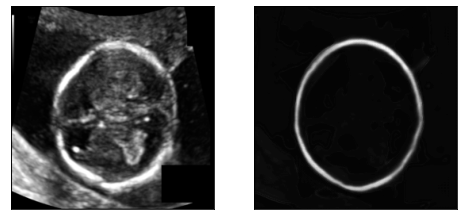

In [22]:
segmenter = ImageSegmentation()
img = Image.open("test_set/111_HC.png")
image, out = segmenter.segment(img)
reversed_tf = transforms.ToPILImage()
out = reversed_tf(out.squeeze(0))
image = reversed_tf(image.squeeze(0))

plt.figure(figsize = (8,8))
plt.subplot(121), plt.imshow(image, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()